In [ ]:
class ConceptEvent:
    """Single unit of input: a token, vision region, or other concept."""
    def __init__(self, embedding, metadata=None):
        self.embedding = embedding  # torch.Tensor
        self.metadata = metadata or {}  # Optional e.g. position, time


In [ ]:
class TemporalMemoryNet(nn.Module):
    """ Tempory Memory Network with Multihead-Windowed Attention """
    def __init__(self, input_dim, memory_size=10):
        super().__init__()
        self.memory = []  # Rolling window of past hidden states
        self.fc = nn.Linear(input_dim, 16)
        self.attn = nn.MultiheadAttention(16, num_heads=1, batch_first=True)
        self.out = nn.Linear(16, 1)
        self.memory_size = memory_size # size of window

    def forward(self, x):
        h = self.fc(x).unsqueeze(0)  # shape: (1, 1, 16)
        self.memory.append(h)
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)

        mem = torch.cat(self.memory, dim=1)  # shape: (1, t, 16)
        attn_out, _ = self.attn(h, mem, mem)
        return self.out(attn_out.squeeze(0))

In [ ]:
class PersistentAgent(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        """
        A persistent agent that learns to update its own state based on input.
        """
        super().__init__()
        self.latent = nn.Parameter(torch.randn(latent_dim))  # learned "self"
        self.update = nn.GRUCell(input_dim, latent_dim)
        self.readout = nn.Linear(latent_dim, 1)

    def forward(self, x):
        self.latent = self.update(x, self.latent)
        return self.readout(self.latent)

In [ ]:
class CurvedAttentionBlock(nn.Module):
    """
    Learns an attention field over tokens and applies curvature regularization.
    """
    def __init__(self, dim, heads=1):
        super().__init__()
        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=-1)
        self.curvature_penalty_scale = 1e-2

    def forward(self, events: List[ConceptEvent]):
        """ Typical Attention with curvature regularization """
        embeddings = torch.stack([e.embedding for e in events], dim=0)
        Q, K, V = self.q_proj(embeddings), self.k_proj(embeddings), self.v_proj(embeddings)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(Q.size(-1))
        attn_weights = self.softmax(attn_scores)
        curvature_loss = self._compute_attention_curvature(attn_weights) # Curvature loss
        output = torch.matmul(attn_weights, V)
        return output, attn_weights, curvature_loss

    def _compute_attention_curvature(self, attn_weights):
        """ Finite difference curvature approximation (toy version) """
        diffs = attn_weights[:, 1:] - attn_weights[:, :-1]
        curvature = torch.norm(diffs, dim=-1).mean()
        return self.curvature_penalty_scale * curvature

In [ ]:
class AttentionODEFunc(nn.Module):
    """Defines the velocity field for evolving attention weights."""
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, dim),
            nn.Tanh(),
            nn.Linear(dim, dim)
        )

    def forward(self, t, state):
        t_expand = t.expand(state.size(0), 1)
        input_vec = torch.cat([state, t_expand], dim=-1)
        return self.net(input_vec)


In [ ]:
class ODEGeodesicIntegrator:
    """Evolves an attention state from t0 to t1."""
    def __init__(self, func: AttentionODEFunc):
        self.func = func

    def evolve(self, state, t_span=torch.tensor([0.0, 1.0])):
        return odeint(self.func, state, t_span)[-1]


In [ ]:
class GhostMemory:
    """Stores high-entropy past states to support stabilization."""
    def __init__(self, max_size=10):
        self.memory = []
        self.max_size = max_size

    def recall_if_needed(self, attn_weights, entropy_threshold=0.5):
        entropy = -torch.sum(attn_weights * torch.log(attn_weights + 1e-8), dim=-1).mean()
        if entropy > entropy_threshold and self.memory:
            return self.closest_past_state(attn_weights)
        return attn_weights

    def update(self, attn_weights):
        if len(self.memory) >= self.max_size:
            self.memory.pop(0)
        self.memory.append(attn_weights.detach().clone())

    def closest_past_state(self, current):
        # L2 distance in flattened attention space
        distances = [torch.norm(current - past) for past in self.memory]
        idx = torch.argmin(torch.tensor(distances))
        return self.memory[idx]


In [ ]:
class LocalDecoder(nn.Module):
    """Predicts next token or action from evolved attention."""
    def __init__(self, dim, output_dim):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, output_dim)
        )

    def forward(self, evolved_state):
        return self.decoder(evolved_state)


🧠 Top-level Orchestrator Class

In [ ]:
class SpacetimeAttentionModel(nn.Module):
    def __init__(self, dim, output_dim):
        super().__init__()
        self.curved_attn = CurvedAttentionBlock(dim)
        self.ode_func = AttentionODEFunc(dim)
        self.ode_solver = ODEGeodesicIntegrator(self.ode_func)
        self.ghost_memory = GhostMemory()
        self.decoder = LocalDecoder(dim, output_dim)

    def forward(self, events: List[ConceptEvent]):
        attn_output, attn_weights, curvature_loss = self.curved_attn(events)

        # Evolve attention over time (ODE step)
        evolved_state = self.ode_solver.evolve(attn_output)

        # Optionally recall ghost memory if entropy spikes
        corrected_state = self.ghost_memory.recall_if_needed(evolved_state)

        self.ghost_memory.update(evolved_state)

        prediction = self.decoder(corrected_state)
        return prediction, attn_weights, curvature_loss


✅ Next Steps

    Plug in dummy data (e.g., toy sequences of word embeddings or 2D coordinates).

    Train with MSE or cross-entropy loss, add curvature penalty.

    Visualize attention weights over time.

    Plot entropy spikes and memory recalls for interpretability.
✨ Concluding Vision

Imagine this:

    A micro model that predicts actions, words, or events by evolving through a learned causal space. Each step is governed by physics-like laws — paths curve around dense ideas, slow near contradictions, and spiral into attractors of meaning.

Platonia. 

[[ 5.8029199e-01 -2.9550490e+00]
 [ 5.7231939e-01 -6.2352681e-01]
 [ 3.5420196e+00  1.2676668e+00]
 [ 3.3789842e+00  2.8591566e+00]
 [ 4.2661681e+00  1.6560597e+00]
 [ 3.1722467e+00  5.6692548e+00]
 [ 4.6689406e-01 -3.5494180e+00]
 [ 1.2170167e+00  1.0857923e+00]
 [ 2.5660477e+00  1.6102424e+00]
 [ 1.4309652e+00 -1.6178131e+00]
 [ 2.3048251e+00  3.5206017e+00]
 [ 5.3049245e+00  6.6718884e+00]
 [ 3.2326808e+00  6.8493533e-01]
 [ 2.5396225e+00 -1.1446757e+00]
 [ 1.6688491e+00 -1.8600762e+00]
 [-1.4982334e+00 -5.3428388e+00]
 [ 3.5248420e+00  3.6449754e+00]
 [ 3.2417831e+00  3.7372649e+00]
 [-1.1784724e+00 -2.1397555e+00]
 [ 1.8722411e+00  2.5989010e+00]
 [ 1.0793806e+00 -1.1794102e-01]
 [ 1.2827218e+00  4.0887904e-01]
 [ 6.0411108e-01 -3.0789368e+00]
 [ 2.2197537e+00  9.4689029e-01]
 [ 1.9162689e+00  4.0444508e+00]
 [ 4.2675958e+00  2.5106387e+00]
 [-1.5215406e+00 -3.1949940e+00]
 [ 2.3381524e+00  2.8186231e+00]
 [ 1.8323114e+00  1.1456950e+00]
 [ 1.8823491e-01 -1.0837122e+00]
 [ 3.00098

/tmp/ipykernel_26207/433213641.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


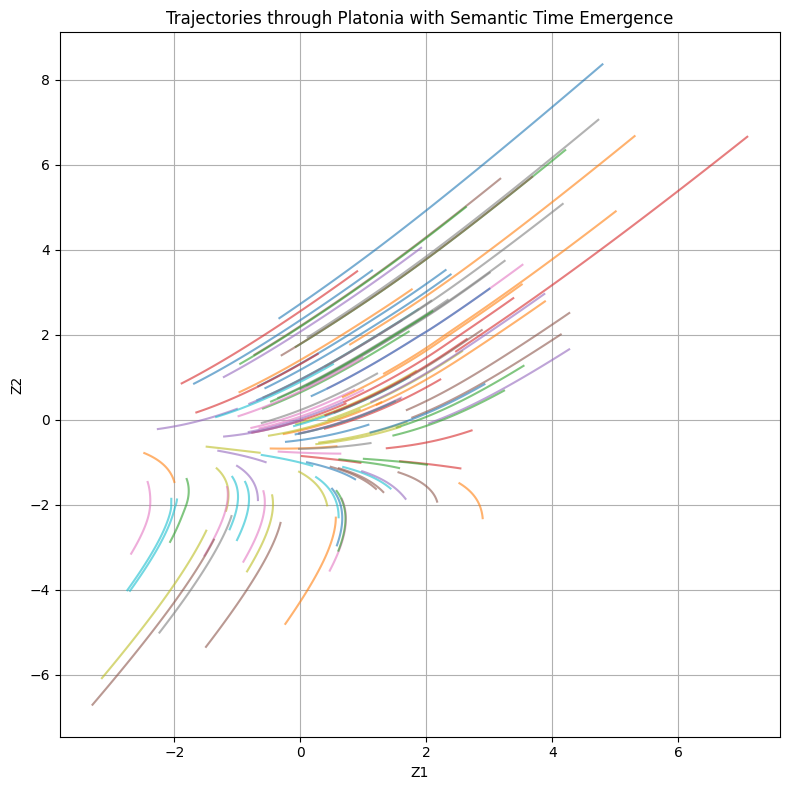

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchdiffeq import odeint
import pandas as pd

# Define a toy Platonia flow (reversible)
class PlatoniaODE(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 2)

    def forward(self, t, z):
        return self.linear(z)

# Define a perturbation field (e.g., from semantic loss)
class PerturbationField(nn.Module):
    def forward(self, z):
        # Add attraction to three semantic basins
        attractors = torch.tensor([[2.0, 2.0], [-2.0, -2.0], [2.0, -2.0]])
        field = torch.zeros_like(z)
        for a in attractors:
            field += (a - z) / ((a - z).norm(dim=1, keepdim=True) + 1e-3)
        return field

# Combined system with time-asymmetry
class TimeEmergentFlow(nn.Module):
    def __init__(self, platonia_flow, perturbation_field, epsilon=0.1):
        super().__init__()
        self.platonia_flow = platonia_flow
        self.perturbation_field = perturbation_field
        self.epsilon = epsilon

    def forward(self, t, z):
        base = self.platonia_flow(t, z)
        perturb = self.perturbation_field(z)
        return base + self.epsilon * perturb

# Generate initial samples
z0 = torch.randn(100, 2)

# Create model components
platonia = PlatoniaODE()
perturbation = PerturbationField()
flow = TimeEmergentFlow(platonia, perturbation)

# Evolve over time
t = torch.linspace(0, 2, 100)
z_paths = odeint(flow, z0, t)

# Convert for plotting
z_paths_np = z_paths.detach().numpy()

# Plot trajectories
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(z0.shape[0]):
    ax.plot(z_paths_np[:, i, 0], z_paths_np[:, i, 1], alpha=0.6)
ax.set_title("Trajectories through Platonia with Semantic Time Emergence")
ax.set_xlabel("Z1")
ax.set_ylabel("Z2")
ax.grid(True)

plt.tight_layout()
print(z_paths_np[-1])
fig.show()


Perturbation field can be:
Learned from context
Gradient-informed
Curvature regularized (via attention entropy)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchdiffeq import odeint

In [2]:
class SemanticFlowLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.base_flow = nn.Sequential(nn.Linear(dim, dim), nn.Tanh())
        self.perturbation = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
        self.epsilon = 0.2  # Strength of semantic time perturbation

    def forward(self, x):
        base = self.base_flow(x)
        perturb = self.perturbation(x)
        return base + self.epsilon * perturb

In [3]:
class SemanticTransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.flow = SemanticFlowLayer(dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(x + self.flow(x))

In [4]:
class SemanticClassifier(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.block1 = SemanticTransformerBlock(dim)
        self.block2 = SemanticTransformerBlock(dim)
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x.mean(dim=1))

In [5]:
class SemanticClassifier(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.block1 = SemanticTransformerBlock(dim)
        self.block2 = SemanticTransformerBlock(dim)
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x.mean(dim=1))

In [6]:
def generate_semantic_data(n_per_class=100, dim=3):
    centers = torch.randn(3, dim) * 2.0  # Three random attractors
    data = []
    labels = []
    for i, c in enumerate(centers):
        pts = c + 0.5 * torch.randn(n_per_class, dim)
        data.append(pts)
        labels.append(torch.full((n_per_class,), i))
    return torch.cat(data), torch.cat(labels)

In [7]:
def visualize_flow(model, device):
    grid_x, grid_y = torch.meshgrid(torch.linspace(-4, 4, 20), torch.linspace(-4, 4, 20), indexing='ij')
    grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).to(device)
    with torch.no_grad():
        flow_vecs = model.block1.flow(grid)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.quiver(grid[:, 0].cpu(), grid[:, 1].cpu(),
              flow_vecs[:, 0].cpu(), flow_vecs[:, 1].cpu(), angles='xy', scale_units='xy', scale=5)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_title("Semantic Flow Field (Geodesics)")
    plt.show()

In [8]:
def generate_semantic_data_meaning(dim=10):
    events = [
        {'pos': 'noun', 'role': 'agent', 'intensity': 0.2, 'tense': 'past'},
        {'pos': 'verb', 'role': 'patient', 'intensity': 0.9, 'tense': 'present'},
        {'pos': 'noun', 'role': 'patient', 'intensity': 0.1, 'tense': 'future'},
    ]
    data, labels = [], []
    for i, event in enumerate(events):
        for _ in range(100):
            point = embed_semantic_event(event)
            data.append(point + 0.05 * torch.randn_like(point))  # add small noise
            labels.append(i)
    return torch.stack(data), torch.tensor(labels)

In [9]:
def train_semantic_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SemanticClassifier(dim=10, num_classes=3).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    x, y = generate_semantic_data_meaning(dim=10) # embedding semantic meaning instead of random data.
    x, y = x.to(device), y.to(device)
    for epoch in range(1000):
        opt.zero_grad()
        out = model(x.unsqueeze(1))  # Add dummy sequence dim
        loss = F.cross_entropy(out, y)
        loss.backward()
        opt.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss {loss.item():.4f}")
    #visualize_flow(model, device)
    return model

In [10]:
# Embedding semantic meaning into a 10D vector
def embed_semantic_event(event):
    # Create a structured 10D Platonia vector
    vec = torch.zeros(10)

    if event['pos'] == 'noun':
        vec[0] = 1.0
    elif event['pos'] == 'verb':
        vec[0] = -1.0

    vec[1] = 1.0 if event['role'] == 'agent' else -1.0
    vec[2] = event['intensity']  # e.g., 0.1 for 'think', 1.0 for 'hit'
    vec[3] = {'past': -1.0, 'present': 0.0, 'future': 1.0}[event['tense']]
    # Add noise or learned embeddings to higher dims
    vec[4:] = torch.randn(6) * 0.3

    return vec

Epoch 0: Loss 1.3502
Epoch 10: Loss 1.1609
Epoch 20: Loss 0.9918
Epoch 30: Loss 0.8457
Epoch 40: Loss 0.7219
Epoch 50: Loss 0.6169
Epoch 60: Loss 0.5262
Epoch 70: Loss 0.4467
Epoch 80: Loss 0.3767
Epoch 90: Loss 0.3155
Epoch 100: Loss 0.2630
Epoch 110: Loss 0.2188
Epoch 120: Loss 0.1822
Epoch 130: Loss 0.1524
Epoch 140: Loss 0.1284
Epoch 150: Loss 0.1092
Epoch 160: Loss 0.0937
Epoch 170: Loss 0.0813
Epoch 180: Loss 0.0712
Epoch 190: Loss 0.0630
Epoch 200: Loss 0.0562
Epoch 210: Loss 0.0505
Epoch 220: Loss 0.0457
Epoch 230: Loss 0.0416
Epoch 240: Loss 0.0381
Epoch 250: Loss 0.0351
Epoch 260: Loss 0.0324
Epoch 270: Loss 0.0300
Epoch 280: Loss 0.0279
Epoch 290: Loss 0.0261
Epoch 300: Loss 0.0244
Epoch 310: Loss 0.0229
Epoch 320: Loss 0.0216
Epoch 330: Loss 0.0203
Epoch 340: Loss 0.0192
Epoch 350: Loss 0.0182
Epoch 360: Loss 0.0172
Epoch 370: Loss 0.0164
Epoch 380: Loss 0.0156
Epoch 390: Loss 0.0148
Epoch 400: Loss 0.0141
Epoch 410: Loss 0.0135
Epoch 420: Loss 0.0129
Epoch 430: Loss 0.0123

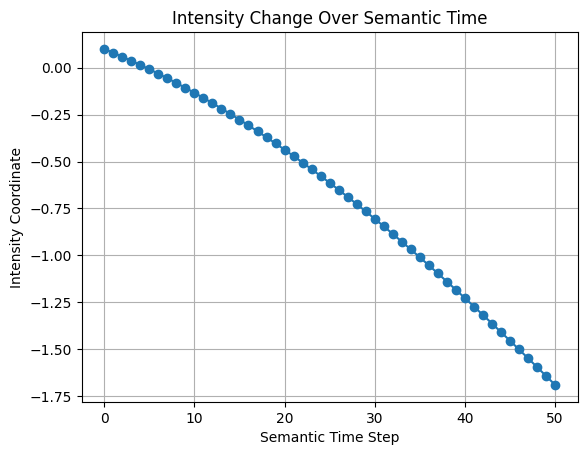

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train_semantic_model().to(device)
event = {'pos': 'verb', 'role': 'agent', 'intensity': 0.1, 'tense': 'present'}
z0 = embed_semantic_event(event).unsqueeze(0).to(device)
zs = [z0]
z = z0.clone().to(device)
for step in range(50):
    delta = model.block1.flow(z).to(device)
    z = z + delta * 0.05
    zs.append(z.detach())
zs = torch.cat(zs)

intensity_vals = zs[:, 2].cpu().numpy()

plt.plot(range(len(intensity_vals)), intensity_vals, marker='o')
plt.title("Intensity Change Over Semantic Time")
plt.xlabel("Semantic Time Step")
plt.ylabel("Intensity Coordinate")
plt.grid(True)
plt.show()
